# Kaggle Days Warsaw 2018 - Part 2

This year on 18-19 of May I had an opportunity to take part in first ever offline kaggle competition - Kaggle Days Warsaw 2018. The competition goal was to predict the number of upvotes for given reddit answers, having information such as time or post content. Of all competing teams (around 40) my team was finally 12th. It's far from awesome, but given we compteted against much more experienced people (and Kaggle Masters) I consider this a decent result.

My aim is to improve our result and check which place could we reach with some improvements in our code. This is my second notebook related to this problem - the first one focused solely on data exploration and feature engineering. Now, I'll use insights from it to build a model and do some prediction. 

In [1]:
#Some casual imports
#data manipulation
import numpy as np
import pandas as pd

#dataviz
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


#for sklearn pipelines and modelling
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import SGDRegressor

#this should be helpful
import re
from math import log

#boosting
#import xgboost as xgb
import lightgbm as lgb

In [2]:
#This idea comes from baseline kernel from the competition https://www.kaggle.com/piotrekga/baseline-solution-reddit
#all credit to original creator

def load_data(filename="../kaggledays/train.csv"):
    data = pd.read_csv(filename, sep="\t", index_col='id')
    msg = "Reading the data ({} rows). Columns: {}"
    print(msg.format(len(data), data.columns))
    # Select the columns
    #this time pretty much everything, except target *answer score) and id (which is rather useless)
    X = data.loc[:, ['question_id', 'subreddit', 'question_utc', 'question_text',
       'question_score', 'answer_utc', 'answer_text']]
    
    
    try:
        y = data.loc[:, "answer_score"]
    except KeyError: # There are no answers in the test file
        return X, None
    return X, y

X, y = load_data()
#X_train, X_test, y_train, y_test = train_test_split(X, y)

Reading the data (852885 rows). Columns: Index(['question_id', 'subreddit', 'question_utc', 'question_text',
       'question_score', 'answer_utc', 'answer_text', 'answer_score'],
      dtype='object')


In [3]:
#our success metric
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(
        np.mean((np.log1p(y) - np.log1p(y0)) ** 2)
    )

In [4]:
#some type conversion
coltypes = {"question_id":"str", 
            "subreddit":"str", 
            "question_utc":"datetime64[s]",
            "question_text": "str", 
            "question_score":"int32", #notice how large these values are
            "answer_utc":"datetime64[s]",
            "answer_text":"str", 
            "answer_score":"int32"} #check

for col, coltype in coltypes.items():
    if col in X.columns:
        X[col] = X[col].astype(coltype)

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852885 entries, 330435 to 2646893
Data columns (total 7 columns):
question_id       852885 non-null object
subreddit         852885 non-null object
question_utc      852885 non-null datetime64[ns]
question_text     852885 non-null object
question_score    852885 non-null int32
answer_utc        852885 non-null datetime64[ns]
answer_text       852885 non-null object
dtypes: datetime64[ns](2), int32(1), object(4)
memory usage: 48.8+ MB


In [6]:
X.head()

,question_id,subreddit,question_utc,question_text,question_score,answer_utc,answer_text
id,,,,,,,
330435,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 00:03:36,"I didn't really care for it, I thought the pac..."
1944975,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 01:11:34,"I thought it was hilarious, and I didn't reali..."
2218735,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 01:12:43,"&gt; Pacific Rim The porno, or the studio rel..."
2133251,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 01:22:29,I enjoyed it more than most movies of that gen...
2133252,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 12:56:52,"Its terrible, its clearly made to be a self aw..."


In [7]:
#X.describe()

## EDA/ Data Exploration

We already did this, so I'll skip this part right now - for more detailed EDA check my other notebook

## Let's go!

In [8]:
#this function incorporates basically all my feature ideas
def engineer_features(df):
    
    #text-related features
    df['uppercase_count_q'] = df['question_text'].str.findall(r'[A-Z]').str.len()
    df['uppercase_count_a'] = df['answer_text'].str.findall(r'[A-Z]').str.len()

    df["answer_count"] = df.groupby(['question_id'])['answer_text'].transform('count')
    df["answer_lowcount"] = (df["answer_count"] < 200) * 1

    url_regex = 'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+'
    img_regex = 'https?:[^)''"]+\.(?:jpg|jpeg|gif|png)'

    df['answer_links'] = df['answer_text'].apply(lambda x: len(re.findall(url_regex, x)))
    df['answer_imgs'] = df['answer_text'].apply(lambda x: len(re.findall(img_regex, x)))
    #df['answer_imgs'] = df.answer_imgs.apply(lambda x: 6 if x > 6 else x)
    #df['answer_links'] = df.answer_links.apply(lambda x: 10 if x > 10 else x)

    df['answer_length'] = df['answer_text'].apply(lambda x: len(x))
    df['answer_is_long'] = (df['answer_length'] < 1500) * 1 #this will keep dtype numeric
    df['answer_sents'] = df['answer_text'].apply(lambda x: len(re.findall(r'.*[.!?]', x))) #not 100% accurate but should do the job
    
    #time-related features
    df["answer_delay"] = (df.answer_utc - df.question_utc).dt.total_seconds().apply(lambda x: log(x+1))
    df["answer_day_of_week"] = df["answer_utc"].dt.dayofweek
    df["answer_hour"] = df["answer_utc"].dt.hour
    df["answer_time_of_day"] = df["answer_utc"].dt.hour*24  + df["answer_utc"].dt.minute
    df["answer_holidays"] = (df["answer_utc"] >= '2017-12-24') * 1
    df["time_trend"] = (df["answer_utc"] - df["answer_utc"].min()).dt.total_seconds()/3600
    df["trend_low"] = (df["time_trend"] < 175) * 1
    
    #numeric features
    df['q_score_subreddit_median'] = df.groupby(['subreddit'])['question_score'].transform('median')
    df['q_score_subreddit_mean'] = df.groupby(['subreddit'])['question_score'].transform('mean')
    
    return df.copy()

In [9]:
X_all = engineer_features(X)

In [10]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns, orient=None):
        super(FeatureSelector, self).__init__()
        self.columns = columns

    def fit(self, X, *args, **kwargs):
        return self

    def transform(self, data, *args, **kwargs):
        return data[self.columns].values

In [11]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852885 entries, 330435 to 2646893
Data columns (total 25 columns):
question_id                 852885 non-null object
subreddit                   852885 non-null object
question_utc                852885 non-null datetime64[ns]
question_text               852885 non-null object
question_score              852885 non-null int32
answer_utc                  852885 non-null datetime64[ns]
answer_text                 852885 non-null object
uppercase_count_q           852885 non-null int64
uppercase_count_a           852885 non-null int64
answer_count                852885 non-null int64
answer_lowcount             852885 non-null int64
answer_links                852885 non-null int64
answer_imgs                 852885 non-null int64
answer_length               852885 non-null int64
answer_is_long              852885 non-null int64
answer_sents                852885 non-null int64
answer_delay                852885 non-null float64
answer_da

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y)

In [13]:
excluded_cols = {'answer_text', 'answer_utc','question_id', 'question_text', 'question_utc', 'subreddit'}
use_cols  = list(set(X_train.columns) - excluded_cols)

In [14]:
def build_model():
    process_data = make_union(
        make_pipeline(
            FeatureSelector(use_cols),
        ),
        make_pipeline(
            FeatureSelector("subreddit"),
            TfidfVectorizer(min_df=2, token_pattern="\w+"),
        ),
        make_pipeline(
            FeatureSelector("question_text"),
            TfidfVectorizer(min_df=2, token_pattern="\w+"),
        ),
        make_pipeline(
            FeatureSelector("answer_text"),
            TfidfVectorizer(min_df=2, token_pattern="\w+"),
        ),
    )

    model = make_pipeline(
         process_data,
         lgb.LGBMRegressor(),
    )
    return model

In [15]:
%%time
model = build_model()
model.fit(X_train, np.log1p(y_train))

y_train_theor = np.expm1(model.predict(X_train))
y_test_theor = np.expm1(model.predict(X_test))
print()
print("Training set")
print("RMSLE:   ", rmsle(y_train, y_train_theor))

print("Test set")
print("RMSLE:   ", rmsle(y_test, y_test_theor))


Training set
RMSLE:    0.7558424387757934
Test set
RMSLE:    0.7648141548270421
CPU times: user 11min 32s, sys: 6.86 s, total: 11min 39s
Wall time: 3min 23s


In [18]:
X_val, _ = load_data('../kaggledays/test.csv')

coltypes = {"question_id":"str", 
            "subreddit":"str", 
            "question_utc":"datetime64[s]",
            "question_text": "str", 
            "question_score":"int32", #notice how large these values are
            "answer_utc":"datetime64[s]",
            "answer_text":"str", 
            "answer_score":"int32"} #check

for col, coltype in coltypes.items():
    if col in X_val.columns:
        X_val[col] = X_val[col].astype(coltype)

X_val = engineer_features(X_val)
solution = pd.DataFrame(index=X_val.index)
solution['answer_score'] = np.expm1(model.predict(X_val))
solution.to_csv('submission.csv')

Reading the data (663082 rows). Columns: Index(['question_id', 'subreddit', 'question_utc', 'question_text',
       'question_score', 'answer_utc', 'answer_text'],
      dtype='object')


### Some Kaggle magic...

During the competition, there was some kind of data leak. The data (some of scores we were trying to predict) was made available to everyone, so we can improve our submission by simple substitution.

In [63]:
leaks = pd.read_csv("leaked_records.csv",  index_col='id').rename(columns={"answer_score": "leak"})

In [44]:
leaks.head()

,leak
id,
999144,1
4126545,1
3143820,3
6738768,5
1744091,4


In [57]:
sub = solution.copy() # just in case - this will be our improved submission with 'leaks'

In [58]:
#so called "magic coefficient", already used in e.g. toxic comment classification challenge - sigificantly improves score
sub.answer_score = sub.answer_score * 0.8 

In [59]:
#subsitute
sub.loc[leaks.index,'answer_score'] = leaks.leak

In [61]:
#check
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663082 entries, 273508 to 5814748
Data columns (total 1 columns):
answer_score    663082 non-null float64
dtypes: float64(1)
memory usage: 30.1 MB


In [62]:
sub.to_csv('sub.csv')

### Leaderboard

Of course competition already ended, but we can still make late submission to check how good would our prediction be if submitted on time.

In [66]:
from IPython.display import Image

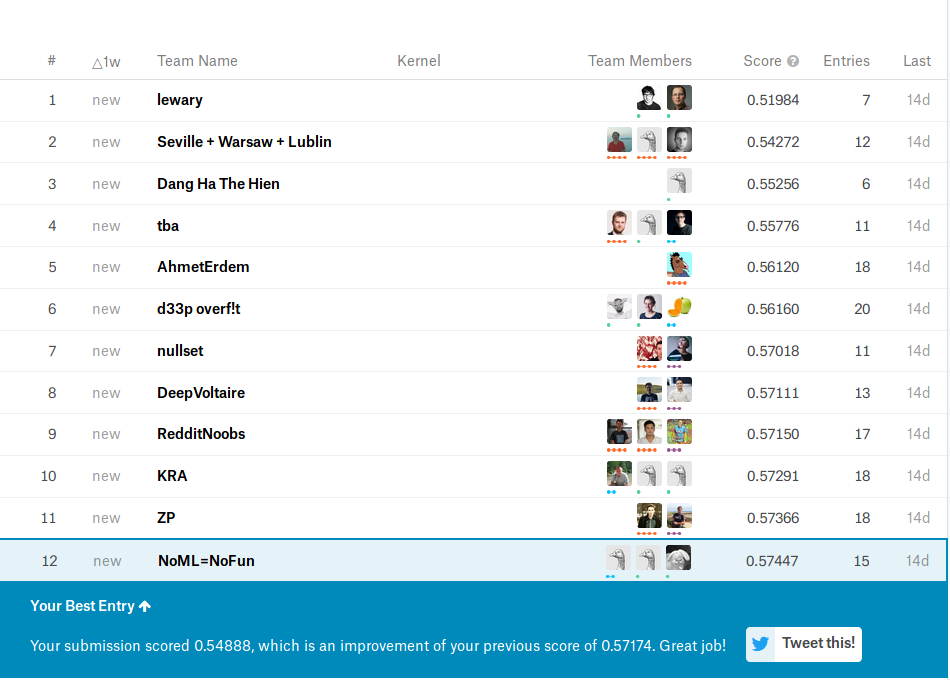

In [67]:
Image("../kaggledays/ldbrd.png")

Wow! It seems that with these improvements we would move from 12th to 3rd place. Really good, although 12 place reached in a fair competition against Kaggle Masters is also decent result. 

### To do/ next improvements:
1. Some hyperparameter tunning (i used default ones)
2. New features
3. Feature importnace/selection
4. Different algorithms
5. Blending/stacking
6. Remove some outliers from training set